In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import pickle
import pmdarima as pm
from sklearn.preprocessing import StandardScaler


## 1) Importing Data 

In [2]:
sp500=yf.download('^NSEI',start="2018-01-01", end="2022-12-31",interval='1d')

[*********************100%***********************]  1 of 1 completed


In [3]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,10477.549805,10495.200195,10404.650391,10442.200195,10442.200195,153400
2018-01-03,10482.650391,10503.599609,10429.549805,10443.200195,10443.200195,167300
2018-01-04,10469.400391,10513.000000,10441.450195,10504.799805,10504.799805,174900
2018-01-05,10534.250000,10566.099609,10520.099609,10558.849609,10558.849609,180900
2018-01-08,10591.700195,10631.200195,10588.549805,10623.599609,10623.599609,169000


In [4]:
sp500['Returns %']=sp500['Adj Close'].diff() / sp500['Adj Close']

In [5]:
sp500.head()

,Open,High,Low,Close,Adj Close,Volume,Returns %
Date,,,,,,,
2018-01-02,10477.549805,10495.200195,10404.650391,10442.200195,10442.200195,153400,NaN
2018-01-03,10482.650391,10503.599609,10429.549805,10443.200195,10443.200195,167300,0.000096
2018-01-04,10469.400391,10513.000000,10441.450195,10504.799805,10504.799805,174900,0.005864
2018-01-05,10534.250000,10566.099609,10520.099609,10558.849609,10558.849609,180900,0.005119
2018-01-08,10591.700195,10631.200195,10588.549805,10623.599609,10623.599609,169000,0.006095


<AxesSubplot:xlabel='Date'>

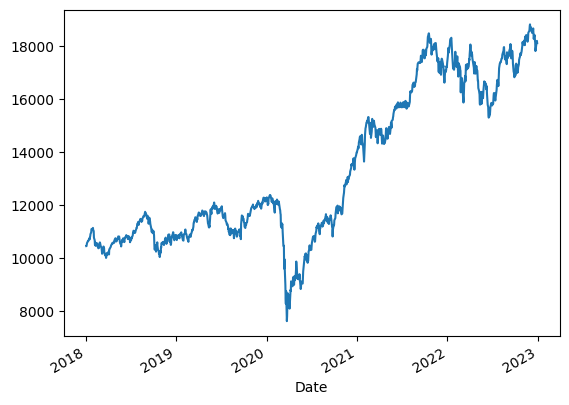

In [6]:
sp500['Adj Close'].plot()

<AxesSubplot:xlabel='Date'>

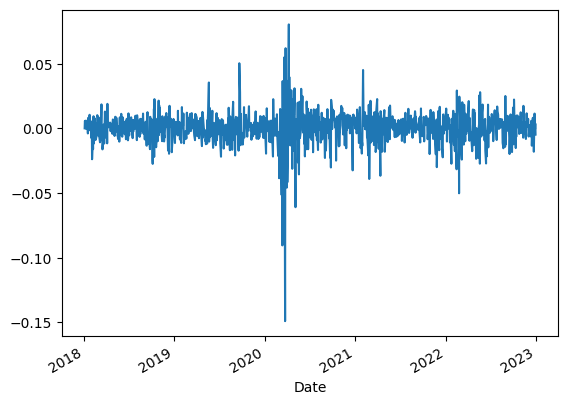

In [7]:
sp500['Returns %'].plot()

In [8]:
# sp500['Adj Close'].ewm(span=100).mean().plot()

In [9]:
# sp500['Adj Close']=sp500['Adj Close'].ewm(span=80).mean()

<AxesSubplot:xlabel='Date'>

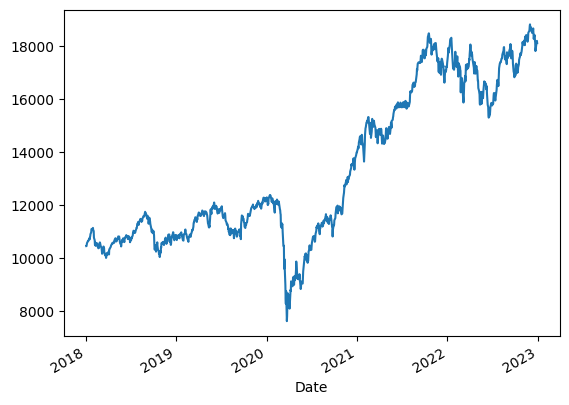

In [10]:
sp500['Adj Close'].plot()

The cyclical component represents phenomena that happen across seasonal periods. Cyclical patterns do not have a fixed period like seasonal patterns do. An example of a cyclical pattern is the cycles of boom and bust that stock markets experience in response to world events. <br>
This data seems to have cyclical component with no consistent cyclicity. So instead of decomposing it into trend, seasonality, noise, we would just keep it as it is.

In [11]:
sp500['Adj Close'].shape

(1232,)

Figure(640x480)


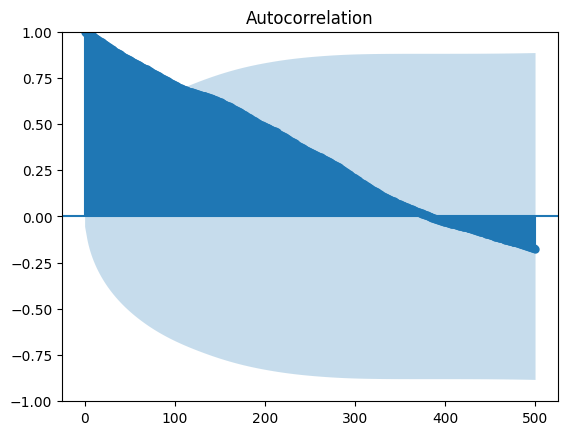

In [12]:
print(plot_acf(sp500['Adj Close'],lags=500))

Also autocorrelation graph shows no seasonal pattern.

## 4) Model

In [13]:
# sp500.loc[~np.isnan(np.array(sp500['Log Returns %'])),'Log Returns %']

In [14]:
# sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']

In [15]:
# sp500[sp500['Log Returns %']<-1]

In [16]:
sar = sm.tsa.statespace.SARIMAX(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1), 
                                order=(2,0,1), 
                                seasonal_order=(1,0,0,40), 
                                trend='c').fit()
sar.summary()

# sarima model without seasonality is arima model 

C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           Returns %   No. Observations:                 1231
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 40)   Log Likelihood                3638.591
Date:                             Fri, 10 Mar 2023   AIC                          -7265.183
Time:                                     01:45:27   BIC                          -7234.489
Sample:                                          0   HQIC                         -7253.635
                                            - 1231                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.277e-05      0.000      0.579      0.563      -0.000       0.000
ar.L1          0.6173      0.180      3.422      0.001       0.264       0.971
ar.L2          0.0699      0.012      5.794      0.000       0.046       0.094
ma.L1         -0.6719      0.178     -3.764      0.000      -1.022      -0.322
ar.S.L40       0.0440      0.026      1.671      0.095      -0.008       0.096
sigma2         0.0002   2.58e-06     61.302      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             33642.25
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                            -2.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [88]:
# non seasonal
pm.auto_arima(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1),start_p=1, start_q=1,
                           max_p=3, max_q=3, m=45, 
                           start_P=1, D=0, start_Q=1, max_P=3, max_D=0, max_Q=3,
                               seasonal=False,
                           d=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

C:\Users\hp\miniconda3\envs\kirtesh\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (45) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-7263.689, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-7263.321, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-7265.049, Time=0.41 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-7264.786, Time=0.84 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-7264.434, Time=0.58 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-7266.877, Time=0.45 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-7261.127, Time=0.35 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-7260.485, Time=1.46 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-7269.032, Time=2.07 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-7264.493, Time=0.83 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-7270.231, Time=2.46 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-7261.588, Time=0.34 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-7267.213, Time=2.45 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-7266.935, Time=3.00 sec

Best model:  ARIMA

ARIMA(order=(1, 0, 3), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [89]:
# seasonal
pm.auto_arima(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1),start_p=1, start_q=1,
                           max_p=3, max_q=3, m=40, 
                           start_P=1, D=0, start_Q=1, max_P=3, max_D=0, max_Q=3,
                               seasonal=True,
                           d=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[40] intercept   : AIC=-7260.286, Time=13.95 sec
 ARIMA(0,0,0)(0,0,0)[40] intercept   : AIC=-7261.972, Time=0.67 sec
 ARIMA(1,0,0)(1,0,0)[40] intercept   : AIC=-7263.824, Time=15.21 sec
 ARIMA(0,0,1)(0,0,1)[40] intercept   : AIC=-7263.595, Time=12.66 sec
 ARIMA(0,0,0)(0,0,0)[40]             : AIC=-7263.321, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[40] intercept   : AIC=-7263.777, Time=0.70 sec
 ARIMA(1,0,0)(2,0,0)[40] intercept   : AIC=-7261.768, Time=82.31 sec
 ARIMA(1,0,0)(1,0,1)[40] intercept   : AIC=-7261.773, Time=8.06 sec
 ARIMA(1,0,0)(0,0,1)[40] intercept   : AIC=-7263.118, Time=8.43 sec
 ARIMA(1,0,0)(2,0,1)[40] intercept   : AIC=-7259.864, Time=67.81 sec
 ARIMA(0,0,0)(1,0,0)[40] intercept   : AIC=-7262.223, Time=3.06 sec
 ARIMA(2,0,0)(1,0,0)[40] intercept   : AIC=-7262.919, Time=5.97 sec
 ARIMA(1,0,1)(1,0,0)[40] intercept   : AIC=-7262.357, Time=8.15 sec
 ARIMA(0,0,1)(1,0,0)[40] intercept   : AIC=-7263.586, Time=3.74 sec


ARIMA(order=(2, 0, 1), scoring_args={}, seasonal_order=(1, 0, 0, 40),
      suppress_warnings=True, with_intercept=False)

In [17]:
'''with open('nifty_08_12.pkl', 'wb') as f:
    pickle.dump(sar, f) '''

"with open('nifty_08_12.pkl', 'wb') as f:\n    pickle.dump(sar, f) "

In [18]:
'''with open('nifty_08_12.pkl', 'rb') as f:
    sar = pickle.load(f) '''

"with open('nifty_08_12.pkl', 'rb') as f:\n    sar = pickle.load(f) "

<AxesSubplot:xlabel='Date'>

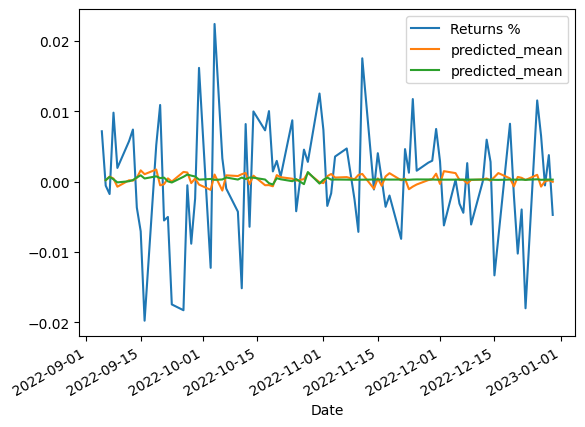

In [22]:
sp500['Returns %'][1150:].plot(legend=True)
sar.predict(start=1150).plot(legend=True)
sar.predict(start=1150,dynamic=True).plot(legend=True)
# sar.forecast(steps=100).plot()
# sp500[730:][['Adj Close', 'Adj Close Forecast']].plot();

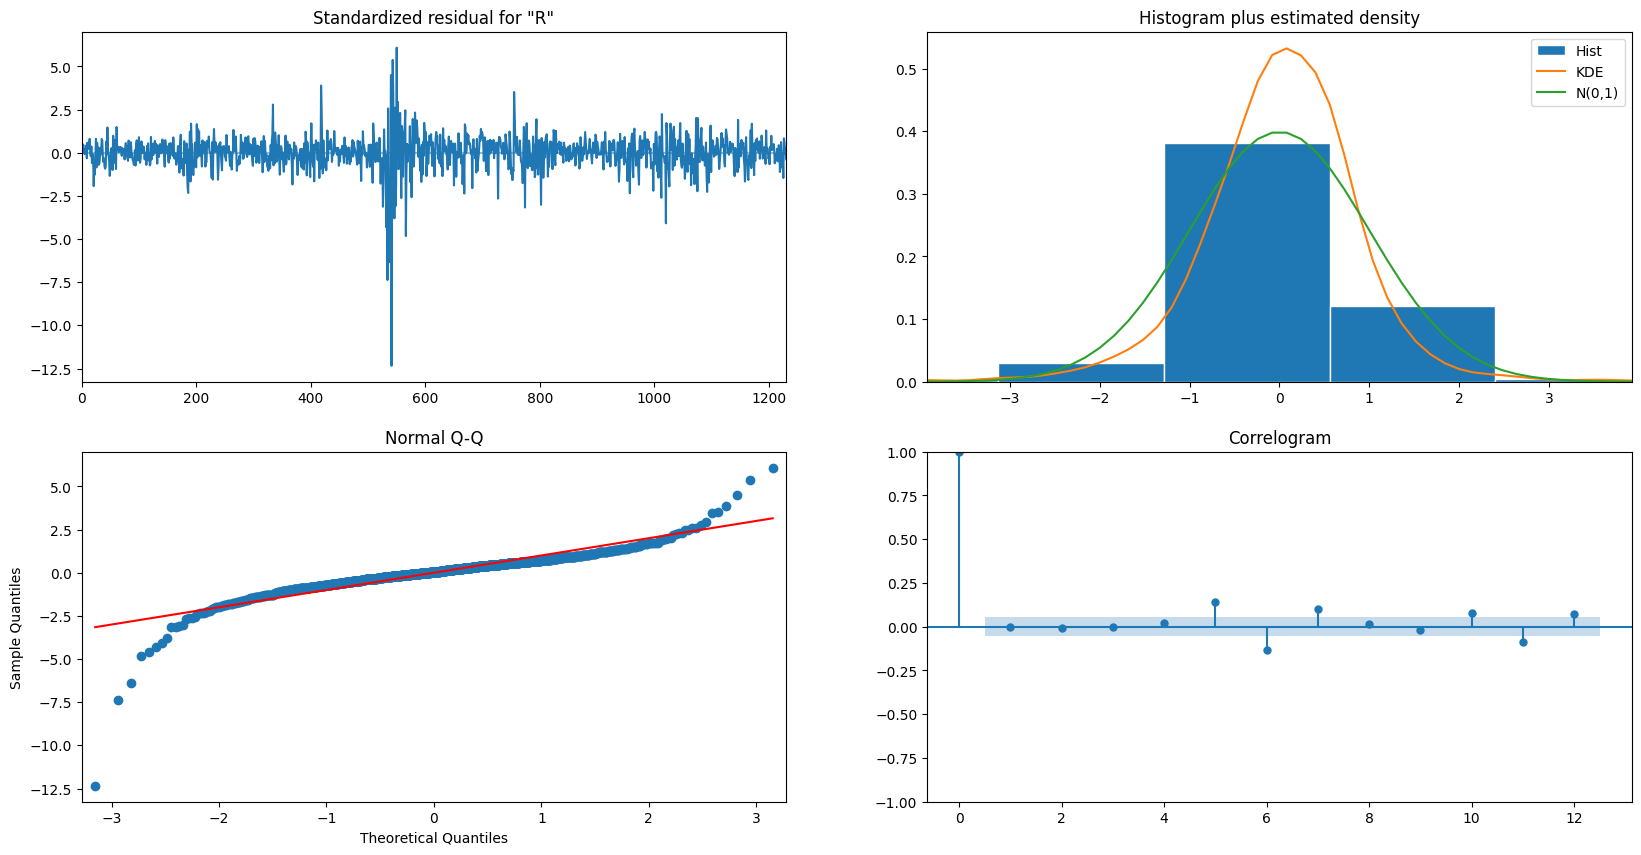

In [23]:
import matplotlib.pyplot as plt
sar.plot_diagnostics(lags=12,figsize = (20,10),)
plt.savefig('ppt_pics/residual_diag_nifty_18_22.png')

In [20]:
def accuracy_sarimax(df1,df2):
    x=np.sign(np.array(df1))==np.sign(np.array(df2))
    
    return sum(x) / len(x)

In [21]:
accuracy_sarimax(np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1),sar.predict())

0.50446791226645

In [95]:
# sp500_fore=yf.download('^NSEI',start="2016-01-01", end="2016-05-15",interval='1d')
# sp500_fore['Adj Close']

In [96]:
# sp500_fore['Returns %']=sp500_fore['Adj Close'].diff() / sp500_fore['Adj Close']

In [97]:
# np.log(sp500_fore.loc[~np.isnan(np.array(sp500_fore['Returns %'])),'Returns %']+1)

In [98]:
# np.log(sp500.loc[~np.isnan(np.array(sp500['Returns %'])),'Returns %']+1).append(sp500_fore['Adj Close'])